## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F

from pytorchClassifiers import Net

In [2]:
# Load the data
df = pd.read_pickle('./data/new-transfer-functions-82000.pkl')
# reduce input size for quicker testing
# df = df.sample(frac=0.1)
df.head()


,phi,g_oo,x,y
0,-20.0,0.001000,"[-1619443.35975, -1614550.781623867, -1609658....","[-22.318748715595078, -26.94110311858538, -27...."
1,-20.0,0.001088,"[-1619443.35975, -1614550.781623867, -1609658....","[-17.266355322587795, -24.53201635526134, -35...."
2,-20.0,0.001185,"[-1619443.35975, -1614550.781623867, -1609658....","[-16.7162220396677, -21.797706698181052, -21.7..."
3,-20.0,0.001289,"[-1619443.35975, -1614550.781623867, -1609658....","[-17.99189952290407, -21.15339387216752, -17.8..."
4,-20.0,0.001403,"[-1619443.35975, -1614550.781623867, -1609658....","[-14.184688148597308, -17.88658030869824, -22...."


In [3]:

phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)

print(df.dtypes)



[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.001      0.0010884  0.00118461 0.00128933 0.0014033  0.00152735
 0.00166237 0.00180932 0.00196926 0.00214334 0.00233281 0.00253902
 0.00276347 0.00300776 0.00327364 0.00356302 0.00387799 0.00422079
 0.00459391 0.005     ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


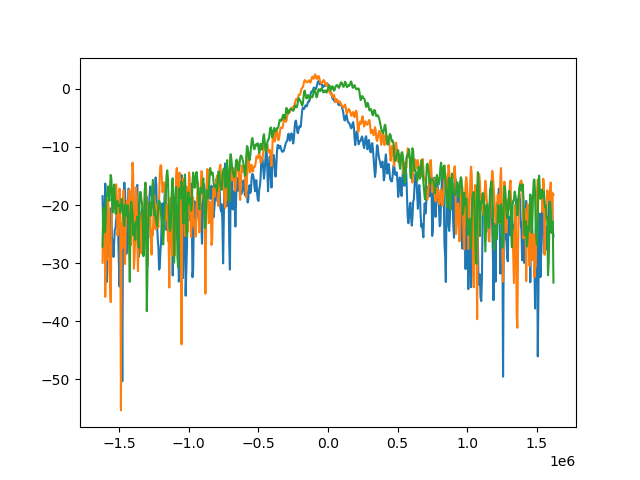

In [4]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [5]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [6]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

target = torch.tensor(target, dtype=torch.uint8)
print(target[5:15])


tensor([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14]], dtype=torch.uint8)


In [7]:
values = np.zeros((len(df), len(df.iloc[0, 0])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row.values[0]
    index += 1
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [8]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
scaled_values = data_scaler.transform(values)
data = torch.tensor(scaled_values)
print(data)

tensor([[-0.7662, -1.0427, -1.1418,  ..., -1.0816, -0.2780, -0.2267],
        [-0.2854, -0.8009, -1.9556,  ..., -0.4223, -1.3402, -0.5441],
        [-0.2331, -0.5264, -0.5350,  ..., -1.0662, -1.5348, -0.2054],
        ...,
        [ 2.1409,  2.9039,  3.0109,  ...,  2.7363,  2.4846,  1.3261],
        [ 1.1487,  1.2162,  0.7184,  ...,  1.6179,  1.6691,  0.7154],
        [ 1.0002,  1.1532,  1.2477,  ...,  1.0257,  0.7687,  0.9511]])


In [9]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(
    data, target, target_original, test_size=0.2, random_state=2)

# further divide X_test in test + validate
X_test, X_validate, y_test, y_validate, y_test_original, y_validate_original = train_test_split(
    X_test, y_test, y_test_original, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

torch.Size([65600, 662])
torch.Size([13120, 662])
torch.Size([3280, 662])
torch.Size([65600, 2])
torch.Size([13120, 2])
torch.Size([3280, 2])


In [10]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 0]))
model1 = Net(n_inputs, n_outputs, name='phase_classifier', activation_func=F.gelu,
             hidden_1=500, hidden_2=200, hidden_3=0,
             avg_pool=(6, 6), trim_edges=135, verbose=1,
             with_batch_norm=True, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss()
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-135, -135), value=0)
  (pool1): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  (fc1): Linear(in_features=65, out_features=500, bias=True)
  (batch_norm1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (batch_norm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
# train the network
train_loss1, train_accuracy1, test_loss1, test_accuracy1 = model1.train_net(
    optimizer1, criterion, X_train, y_train[:, 0].view(-1, ), X_test, y_test[:, 0].view(-1, ), 500)

Epoch 1/500: Test loss decreased (inf --> 3.564454)
Epoch 2/500: Test loss decreased (3.564454 --> 3.259492)
Epoch 3/500: Test loss decreased (3.259492 --> 3.066046)
Epoch 4/500: Test loss decreased (3.066046 --> 2.939440)
Epoch 5/500: Test loss decreased (2.939440 --> 2.827683)
Epoch 6/500: Test loss decreased (2.827683 --> 2.760787)
Epoch 7/500: Test loss decreased (2.760787 --> 2.644361)
Epoch 8/500: Test loss decreased (2.644361 --> 2.572165)
Epoch 9/500: Test loss decreased (2.572165 --> 2.511744)
Epoch 10/500: Test loss decreased (2.511744 --> 2.436320)
Epoch 11/500: Test loss decreased (2.436320 --> 2.404520)
Epoch 12/500: Test loss decreased (2.404520 --> 2.336790)
Epoch 13/500: Test loss decreased (2.336790 --> 2.304729)
Epoch 14/500: Test loss decreased (2.304729 --> 2.265515)
Epoch 15/500: Test loss decreased (2.265515 --> 2.221757)
Epoch 16/500: Test loss decreased (2.221757 --> 2.199387)
Epoch 17/500: Test loss decreased (2.199387 --> 2.154037)
Epoch 18/500: Test loss decr

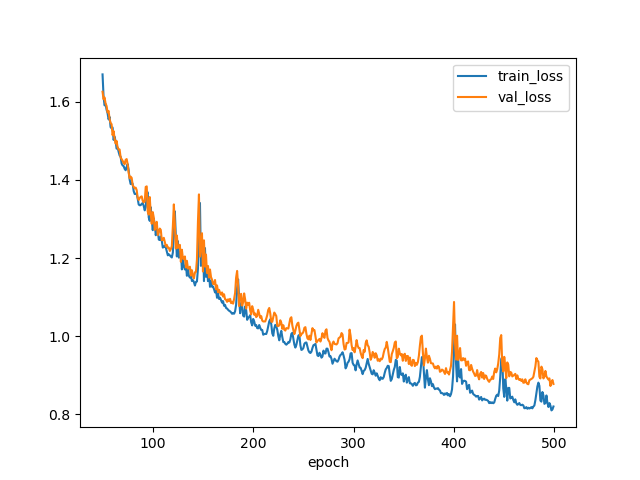

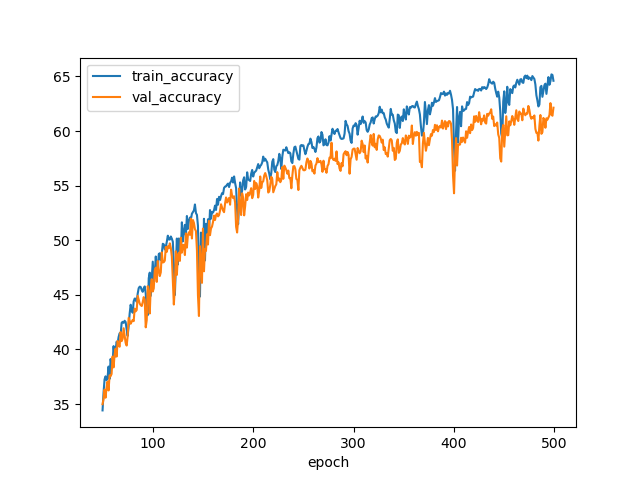

Max accuracy:  62.55335365853659


In [12]:
model1.plot_history(lines=['train_loss', 'val_loss'], epoch=(50, -1))
model1.plot_history(lines=['train_accuracy', 'val_accuracy'], epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy1))

In [16]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 1]))

model2 = Net(n_inputs, n_outputs, name='gain_classifier', activation_func=F.gelu,
             hidden_1=420, hidden_2=350, hidden_3=0,
             avg_pool=(4,4), trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss()
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [19]:
# train the network
train_loss2, train_accuracy2, test_loss2, test_accuracy2 = model2.train_net(
    optimizer2, criterion, X_train, y_train[:, 1].view(-1, ), X_test, y_test[:, 1].view(-1, ), 500)

Epoch 1/300: Test loss decreased (inf --> 0.035740)
Epoch 2/300: Test loss decreased (0.035740 --> 0.034901)
Epoch 3/300: Test loss decreased (0.034901 --> 0.033380)
Epoch 8/300: Test loss decreased (0.033380 --> 0.033162)
Epoch 13/300: Test loss decreased (0.033162 --> 0.033127)
Epoch 15/300: Test loss decreased (0.033127 --> 0.031732)
Epoch 22/300: Test loss decreased (0.031732 --> 0.030943)
Epoch 23/300: Test loss decreased (0.030943 --> 0.030342)
Epoch 24/300: Test loss decreased (0.030342 --> 0.030147)
Epoch 25/300: Test loss decreased (0.030147 --> 0.030005)
Epoch 27/300: Test loss decreased (0.030005 --> 0.029486)
Epoch 28/300: Test loss decreased (0.029486 --> 0.028747)
Epoch 33/300: Test loss decreased (0.028747 --> 0.028173)
Epoch 35/300: Test loss decreased (0.028173 --> 0.027714)
Epoch 37/300: Test loss decreased (0.027714 --> 0.027418)
Epoch 38/300: Test loss decreased (0.027418 --> 0.027051)
Epoch 46/300: Test loss decreased (0.027051 --> 0.026421)
Epoch 50/300, Train Los

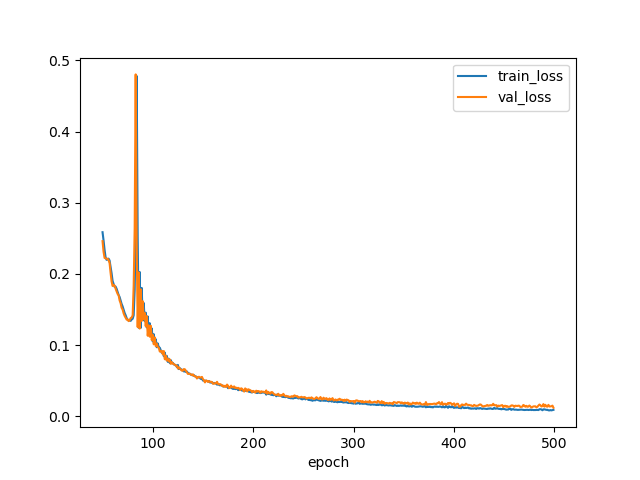

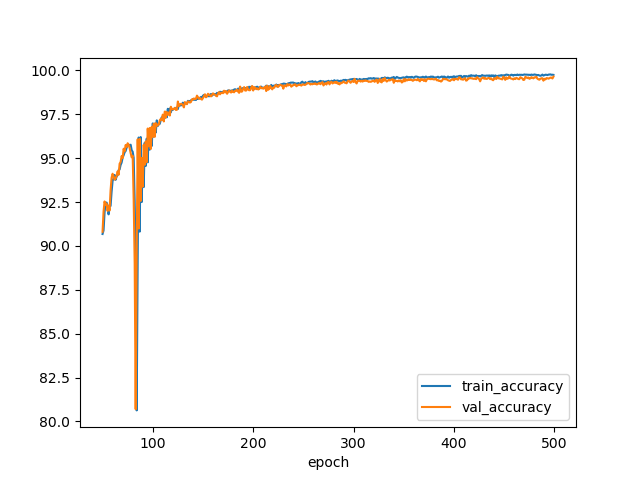

Max accuracy:  99.65701219512195


In [20]:
model2.plot_history(lines=['train_loss', 'val_loss'], epoch=(50, -1))
model2.plot_history(lines=['train_accuracy', 'val_accuracy'], epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy2))


In [37]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 0]))
test_results = []
num_epochs = 100
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4, 4), (6,6)]:
        for hidden_1 in [420, 500]:
            for hidden_2 in [140, 200]:
                for hidden_3 in [0]:
                    for trim_edges in [110, 135]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f" {hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier1', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    avg_pool=(kernel_size, stride), trim_edges=trim_edges,
                                    with_batch_norm=True, save_best=False, verbose=0)
                        criterion = nn.NLLLoss()
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 0].view(-1), X_test, y_test[:, 0].view(-1),
                            num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))


Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,420, 140, 0, 110)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,420, 140, 0, 135)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,420, 200, 0, 110)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,420, 200, 0, 135)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,500, 140, 0, 110)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,500, 140, 0, 135)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,500, 200, 0, 110)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,500, 200, 0, 135)
Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 6, 6,420, 140, 0, 110)
Training net with: activation, kernel_size, stride, h_1, h_2, h_

In [38]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

+------------+-------------+--------+----------+----------+----------+------------+--------------------+
| activation | kernel size | stride | hidden_1 | hidden_2 | hidden_3 | trim_edges |      Min Loss      |
+------------+-------------+--------+----------+----------+----------+------------+--------------------+
|    gelu    |      4      |   4    |   500    |   200    |    0     |    135     | 1.2153187990188599 |
|    gelu    |      6      |   6    |   500    |   200    |    0     |    135     | 1.2257838249206543 |
|    gelu    |      6      |   6    |   420    |   200    |    0     |    135     | 1.2313824892044067 |
|    gelu    |      6      |   6    |   420    |   140    |    0     |    135     | 1.2357397079467773 |
|    gelu    |      6      |   6    |   500    |   200    |    0     |    110     | 1.252055048942566  |
|    gelu    |      4      |   4    |   500    |   140    |    0     |    110     | 1.255881428718567  |
|    gelu    |      6      |   6    |   420    |   200 

In [ ]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 1]))
test_results = []
num_epochs = 150
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4, 4)]:
        for hidden_1 in [420]:
            for hidden_2 in [350]:
                for hidden_3 in [0]:
                    for trim_edges in [120]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier2', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges, save_best=False)
                        criterion = nn.NLLLoss();
                        criterion_name = 'NLLLoss'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 1].view(-1), X_test, y_test[:, 1].view(-1),
                            num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))


In [ ]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

In [31]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/classifier1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load(optimizer1, 'models/phase_classifier-acc62.pt')
model2.load(optimizer2, 'models/gain_classifier-acc99.pt')


In [32]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    freq = torch.tensor(freq).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    freq = F.avg_pool1d(freq, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, freq, sample, **kwargs)

In [33]:
# Get model's predictions
y_pred_phase = model1.get_predictions(X_validate)
y_pred_gain = model2.get_predictions(X_validate)

# Get curve fit predictions
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)
y_optimizer = []
for sample in X_validate:
    popt, _ = curve_fit_deluxe(gen_tf, freq, sample, trim_edges=130, kernel_size=4, stride=1,
                               bounds=([-20, 0.001], [20, 0.005]), method='trf')
    y_optimizer.append(popt)
y_optimizer = np.array(y_optimizer)

/tmp/ipykernel_4169935/500526944.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample).view(1, -1)


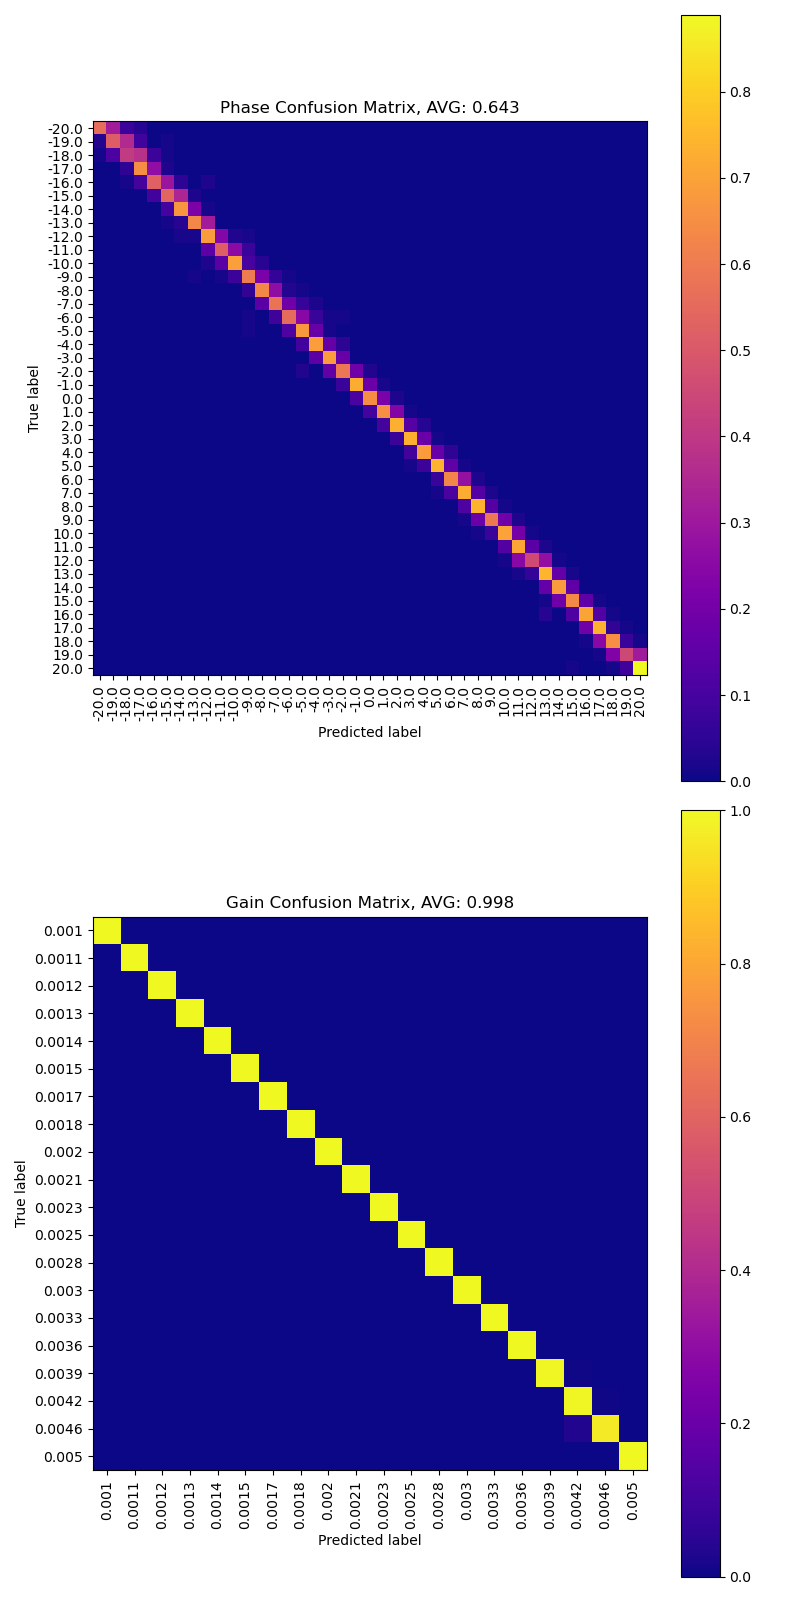

In [34]:
# show confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(figsize=(8, 16), nrows=2)
cm_phase = ConfusionMatrixDisplay.from_predictions(y_validate[:, 0], y_pred_phase,
                                                   xticks_rotation='vertical', ax=ax1,
                                                   normalize='true', include_values=False,
                                                   cmap='plasma', display_labels=phi_encoder.classes_)
ax1.set_title(f'Phase Confusion Matrix, AVG: {np.mean(cm_phase.confusion_matrix.diagonal()):.3f}')

plt.sca(ax1)
plt.tight_layout()

cm_gain = ConfusionMatrixDisplay.from_predictions(y_validate[:, 1], y_pred_gain,
                                                  xticks_rotation='vertical', ax=ax2,
                                                  include_values=False, normalize='true',
                                                  cmap='plasma',
                                                  display_labels=np.round(gain_encoder.classes_, 4))
ax2.set_title(f'Gain Confusion Matrix, AVG: {np.mean(cm_gain.confusion_matrix.diagonal()):.3f}')
plt.sca(ax2)
plt.tight_layout()


In [35]:
# Convert from category to value
y_pred_phase_descaled = phi_encoder.inverse_transform(y_pred_phase)
y_pred_gain_descaled = gain_encoder.inverse_transform(y_pred_gain)
y_pred_descaled = np.array([y_pred_phase_descaled, y_pred_gain_descaled]).T.reshape(-1, 2)

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_pred = r2_score(y_validate_original, y_pred_descaled,
                   multioutput='raw_values')
mae_pred = mean_absolute_error(y_validate_original, y_pred_descaled,
                               multioutput='raw_values')
# mape_pred = mean_absolute_percentage_error(y_validate_original, y_pred_descaled,
#                                       multioutput='raw_values')

r2_opt = r2_score(y_validate_original, y_optimizer,
                  multioutput='raw_values')
mae_opt = mean_absolute_error(y_validate_original, y_optimizer,
                              multioutput='raw_values')
# mape_opt = mean_absolute_percentage_error(y_validate_original, y_optimizer,
#                                       multioutput='raw_values')
print('R2\tPhase\tGain')
print('NeuralNet: ', r2_pred)
print('Optimizer:', r2_opt)

print('MAE\tPhase\tGain')
print('NeuralNet: ', mae_pred)
print('Optimizer:', mae_opt)

# print('MAPE\tPhase\tGain')
# print('NeuralNet: ', mape_pred)
# print('Optimizer:', mape_opt)

R2	Phase	Gain
NeuralNet:  [0.99617832 0.99976756]
Optimizer: [ 0.18765611 -0.66147164]
MAE	Phase	Gain
NeuralNet:  [4.10670732e-01 9.00789101e-07]
Optimizer: [9.25850519e+00 1.34009977e-03]


+-----+-------+-----------------------+-----------------------+-----------------------+
| idx | param |        original       |         model         |          opt          |
+-----+-------+-----------------------+-----------------------+-----------------------+
| 103 |  phi  |         -18.0         |         -17.0         |   -17.83921491043133  |
| 103 |  g_oo | 0.0027052631578947366 | 0.0027052631578947366 | 0.0026835940828048768 |
| 154 |  phi  |         -11.0         |         -13.0         |   -4.809071748262477  |
| 154 |  g_oo |  0.006352631578947369 |  0.006352631578947369 |  0.004734850505756075 |
| 376 |  phi  |          15.0         |          15.0         |   6.505169318401395   |
| 376 |  g_oo |  0.004268421052631579 |  0.004268421052631579 |  0.00472959521003164  |
+-----+-------+-----------------------+-----------------------+-----------------------+


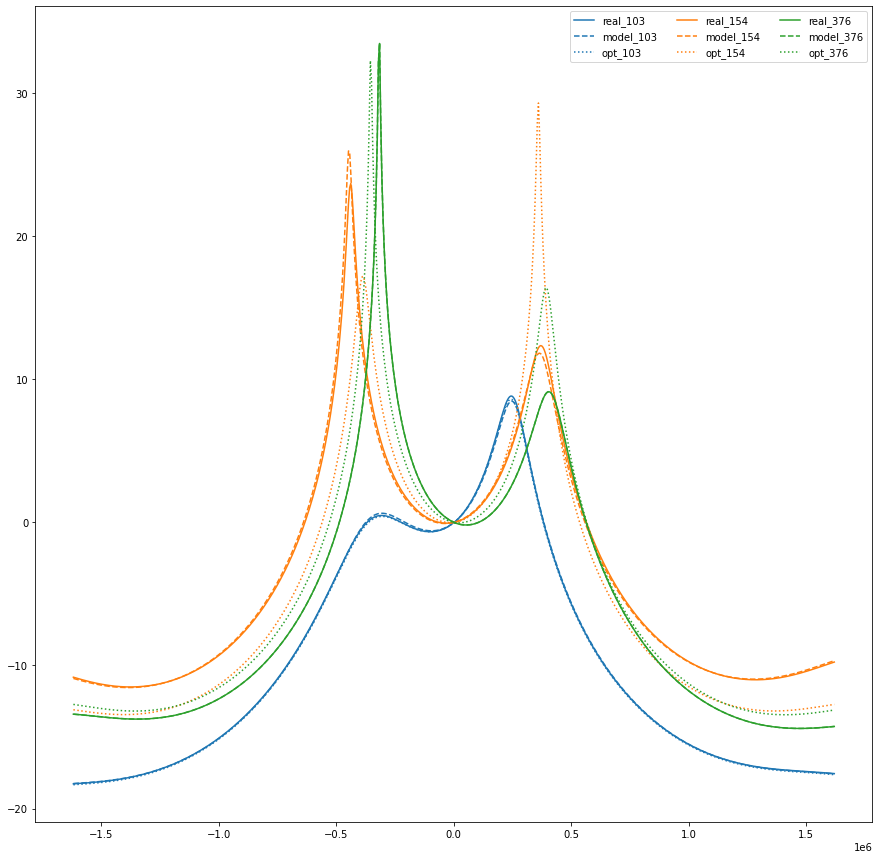

In [19]:
# plot the validation curves
% matplotlib inline

plt.figure(figsize=(15, 15))

table = PrettyTable()
table.field_names = ["idx", "param", "original", "model", "opt"]  #, "model+opt"]
# print(table)

for idx in np.random.choice(np.arange(0, len(X_validate_new)), size=3):
    try:
        popt, _ = curve_fit_deluxe(gen_tf, x, X_validate_new[idx], trim_edges=130, kernel_size=4, stride=1,
                                   bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
        # Initial guesses coming from the model
        # poptModel,_ = curve_fit(gen_tf, x, X_validate_new[idx], bounds=([-20, 1e-4], [20, 1e-2]), method='trf', p0=yhat_new[idx])
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    # print('Param, Original, Model, Optimizer')
    table.add_row([idx, 'phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0]])  #, poptModel[0]])
    table.add_row([idx, 'g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1]])  #, poptModel[1]])

    # print('phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0])
    # print('g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1])

    p = plt.plot(x, gen_tf(x, *(y_validate_new[idx])), label=f'real_{idx}', ls='-')
    plt.plot(x, gen_tf(x, *(yhat_new[idx])), label=f'model_{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, gen_tf(x, *popt), label=f'opt_{idx}', ls=':', color=p[0].get_color())
    # plt.plot(x, gen_tf(x, *poptModel), label=f'opt+model_{idx}', ls='-.', color=p[0].get_color())
print(table)
plt.legend(ncol=3);
# plt.show()
# plt.close()

In [54]:
test_results = []
for trim_edges in [0, 100, 130]:
    for kernel_size, stride in [(1, 1), (4, 1), (4, 4)]:
        print(f"Testing optimizer with: trim_edges, kernel_size, stride, "
              f"= ({trim_edges}, {kernel_size}, {stride})")
        res = calc_mae_optimize(X_validate_new, y_validate_new, trim_edges=trim_edges, kernel_size=kernel_size,
                                stride=stride)
        test_results.append([trim_edges, kernel_size, stride, res[0], res[1]])

Testing optimizer with: trim_edges, kernel_size, stride, = (0, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (0, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (0, 4, 4)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 4, 4)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 4, 4)


In [55]:
table = PrettyTable()
table.field_names = ["trim_edges", "kernel size", "stride", "Loss Phi", "Loss Gain"]
# print(test_results)
test_results.sort(key=lambda x: np.abs(x[-2] + x[-1]))
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

+------------+-------------+--------+---------------------+---------------------+
| trim_edges | kernel size | stride |       Loss Phi      |      Loss Gain      |
+------------+-------------+--------+---------------------+---------------------+
|    130     |      4      |   1    | 0.19449137633619168 | 0.16061078474023235 |
|    130     |      4      |   4    |  0.1944236092347697 | 0.17106378345219067 |
|    130     |      1      |   1    | 0.20039945967490147 |  0.1657807051878679 |
|    100     |      4      |   4    |  0.1915043698187116 | 0.18758920524257522 |
|    100     |      4      |   1    |  0.2110514130529253 | 0.17651401584863413 |
|    100     |      1      |   1    |  0.2098348533505009 | 0.18016524195165373 |
|     0      |      4      |   4    |  0.1949446434863851 | 0.20614696556228096 |
|     0      |      1      |   1    | 0.22333243022745164 |  0.2065953795188629 |
|     0      |      4      |   1    | 0.22995352040649472 | 0.20681222252396136 |
+------------+--